In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']

from glob import glob
import math
import time
import k2flix
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
#-----------------------------------10-------------------------------------

def display_overlay(oid_list,location, start, stop):

    #os.chdir(location)
    all_flux={}
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, oid in enumerate(oid_list):
        flux = pd.read_csv('{}/{}_flux.csv'.format(location,oid),
                          usecols = ['flux_gap','time','error'])
        s = start
        t = stop
        mean = flux.flux_gap.median()
        plt.plot(list(flux.time)[s:t],list(flux.flux_gap/mean)[s:t])
        plt.xlabel('Time (BJD - 2454833 days)')
        plt.ylabel(r'Flux (e- sec$^{-1}$)')
        plt.legend()
    plt.savefig('stars_shortlist/share/{}_{}_{}.png'.format(test,start,stop),dpi=300)
    plt.show()
    return
    
def edges_to_bool(start_stop):
    
    if start_stop.empty:
        return [0]
    else:
        rangeflare = []
        for i,row in start_stop.iterrows():
                rangeflare.append(list(range(int(row.istart),int(row.istop))))
        isflare = np.zeros(start_stop.istop.iloc[-1]+1)
        rangeflare = [item for sublist in rangeflare for item in sublist]
        np.put(isflare,rangeflare,np.ones_like(rangeflare))
        return isflare

def create_inflated_binoms(oid_list,p,maxlen,display=False):

    inflated_binoms={}
    for i in [1,3,5]:
        binom = 0
        for oid in oid_list:
            not_inflated = np.random.binomial(1,p[oid]/i,maxlen//i)
            inflated = [item for sublist in [[j]*i for j in not_inflated] for item in sublist]
            binom = np.add(inflated,binom)
        inflated_binoms[i]=binom
    if display == True:
        plt.plot(inflated_binoms[3])
    
    return inflated_binoms

def remove_systematics(seq,maxlen,maxpoints=5):
    
    #create cleaned data frame:
    systematics = list(seq[maxpoints<seq.sum(axis=1)].index)
    remove = sorted(list(set([item 
                              for sublist in [[i-1,i,i+1] 
                                              for i in systematics] 
                              for item in sublist])))
    seq_drop = seq.drop(labels=remove)
    
    #overlap dirty, overlap clean:
    od = np.asarray([seq[seq.sum(axis=1)>=i].shape[0] for i in range(11)])
    oc = np.asarray([seq_drop[seq_drop.sum(axis=1)>=i].shape[0] for i in range(11)])

    #Calculate the binomial probability for cleaned version
    p = seq.sum()/maxlen
    return od, oc, p, remove

def display_comparison(inflated_binoms, overlap_dirty,overlap_clean, test,cluster):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    lwd=3
    for i,binom in inflated_binoms.items():
        overlap_binom, edges = np.histogram(binom, bins=11, range=(0,10))
        #print(overlap_binom)
        overlap_binom = np.cumsum(overlap_binom[::-1])[::-1]
        #print(overlap_binom,'\n',overlap)
        ax.plot(overlap_binom,
                label='{}-data points binomial distribution'.format(i),
                linewidth=lwd)
    ax.plot(overlap_dirty,
            label='Real distribution with systematic errors',
            c='k',linewidth=lwd)
    ax.plot(overlap_clean,
            label='Real distribution - systematics removed',
            c='k',linestyle='dashed',linewidth=lwd)
   
    #ax.plot(np.array(overlap)-overlap_binom,label='real-random')
    ax.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=1.)
    ax.set_yscale('log')
    plt.xlabel('\# simultaneous FC data points',fontsize=12)
    plt.ylabel('\# data points ( with $\leq$ \# simultaneous FC data points )',fontsize=12)
    plt.xlim(0,10)
    print(os.getcwd())
    plt.savefig('stars_shortlist/share/{}_{}_sys_cuts.png'.format(cluster,test),dpi=300)
    fig.show()
    return

def generate_sequence(oid_list,location):

    #os.chdir(location)

    all_isflare = {}
    rem = []
    for oid in oid_list:
        try:
      
            start_stop = pd.read_csv('{}/{}_flares.csv'.format(location,oid))
            all_isflare[oid] = edges_to_bool(start_stop)
        except FileNotFoundError:
            rem.append(oid)
            continue
    maxlen = max([len(val) for key,val in all_isflare.items()])
    setA = set(oid_list)
    # Get new set with elements that are only in a but not in b
    oid_list = list(setA.difference(rem))
    for key, val in all_isflare.items():
        all_isflare[key] = np.concatenate((val,np.zeros(maxlen-len(val))))
        #print(len(val))
    seq = pd.DataFrame(all_isflare)
    return oid_list, maxlen, seq

def systematic_set(remove):
    '''
    Takes a boolean array of indices to remove and converts them to a list of edges to continuous sets of indices.
    
    Input:
    
    remove - boolean array of indices into flux
    
    Return:
    
    s - Series of 
    
    '''
    s=[]
    j = 0
    for i, item in enumerate(remove[:-1]):
            if item+1 != remove[i+1]:
                s.append(remove[j:i+1])
                j = i+1 
    return s

def systematics_wrap(location, oid_list, test, cluster, maxpoints=5, display=False):
       
    '''
    
    Find systematic errors that can be identified from correlations between LCs in a single campaign 
    and write the indices into flux that need to be removed according to it in a file.
    
    Input:
    
    location - path to data
    oid_list - list of EPIC IDs that have LCs and TargetPixelFiles in the same campaign
    display, save - flags for figure outputs
    
    '''
 
    oid_list, maxlen, seq = generate_sequence(oid_list, location)
    overlap_dirty, overlap_clean, p, remove = remove_systematics(seq,maxlen,maxpoints=maxpoints)
    sys_set = pd.Series([i for item in systematic_set(remove) for i in item])
    inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=display)
    sys_set.to_csv('stars_shortlist/{0}/results/{1}/results/{0}_systematics.csv'.format(cluster,test))
    if display == True:
        display_comparison(inflated_binoms, overlap_dirty, overlap_clean, test,cluster)
        try:
            sys_s = sys_set.drop(sys_set.index[-1])
            j=0
            for i,item in sys_s.iteritems():
                if sys_set[i+1]-sys_set[i] > 1:
                    j+=1
        except IndexError:
            print('No systematics found')
            pass

    return oid_list, sys_set, overlap_dirty


#----------------------------------11-------------------------------------


def find_nearest(array,value):
    '''
    
    Helper function that performs a binary search for the closest value in an array:
    
    Input:
    
    array - sorted array
    value - same type as elements in array
    
    Return:
    
    closest element in array
    index of the closest element in array
    
    '''

    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx


def tpf_time_match(flux, tpf):

    flags = []
    timed = []
    quality = tpf.hdulist[1].data['QUALITY']
    print(time.clock())
    for id_,row in flux.iterrows():

        t, idx_ = find_nearest(tpf.bkjd(), row.time)
        timed.append(t)
        flags.append(quality[idx_])

    flux['tpf_flags'] = flags
    flux['tpf_time'] = timed
    return flux



def parallel_wrap(tpfs, flux, flares,oid,cluster,test,C):
    print(oid)
    try:
        tpfs[oid] = k2flix.TargetPixelFile('stars_shortlist/{}/ktwo{}-c{}_lpd-targ.fits.gz'.format(cluster,oid,C))
    except FileNotFoundError:
        os.chdir('/work1/eilin/appaloosa/appaloosa/stars_shortlist/{}'.format(cluster))
        command = 'wget -q http://archive.stsci.edu/missions/k2/target_pixel_files/c{}/{}00000/{}000/ktwo{}-c{}_lpd-targ.fits.gz'.format(C[1],str(oid)[:4],str(oid)[4:6],oid,C)
        print(command)
        os.system(command)
        print(os.getcwd())
        tpfs[oid] = k2flix.TargetPixelFile('ktwo{}-c{}_lpd-targ.fits.gz'.format(oid,C),cache=False)
        os.chdir('/work1/eilin/appaloosa/appaloosa')
    try:
        flares[oid] = pd.read_csv('stars_shortlist/{}/results/{}/results/{}_flares.csv'.format(cluster,test,oid))

        if glob('stars_shortlist/{}/results/{}/results/{}_tpf_times_FLUX.csv'.format(cluster,test,oid)) == []:
            flux[oid] = pd.read_csv('stars_shortlist/{}/results/{}/results/{}_flux.csv'.format(cluster,test,oid),usecols=['error','flux_gap','time','flux_model'])
            flux[oid] = tpf_time_match(flux[oid],tpfs[oid])
            flux[oid].to_csv('stars_shortlist/{}/results/{}/results/{}_tpf_times_FLUX.csv'.format(cluster,test,oid))
        else:
            flux[oid] = pd.read_csv('stars_shortlist/{}/results/{}/results/{}_tpf_times_FLUX.csv'.format(cluster,test,oid),
                                usecols=['error','flux_gap','time','flux_model','tpf_time','tpf_flags'])
    except FileNotFoundError:
        pass
    print(len(tpfs))
    return tpfs, flux, flares

def wrap_tpf_time_match(oid_list,cluster,test,C):
    tpfs, flux, flares = dict(), dict(), dict()
    for oid in oid_list:
        parallel_wrap(tpfs, flux, flares,oid,cluster,test,C)
    #num_cores = multiprocessing.cpu_count()
    #print('Number of cores: {}'.format(num_cores))
    #Parallel(n_jobs=num_cores-3)(delayed(parallel_wrap)(tpfs,flux,flares,oid,cluster,test,C) for oid in oid_list )

    return flux, flares, tpfs
                                          
def edges_to_bool2(start_stop,flux):
    
    rangeflare = []
    for i,row in start_stop.iterrows():
            rangeflare.append(list(range(int(row.istart),int(row.istop+1))))
    
    isflare = np.zeros_like(flux.time.tolist())
    rangeflare = pd.Series([item for sublist in rangeflare for item in sublist], 
                           dtype=np.int)
    rangeflare = rangeflare[rangeflare < isflare.shape[0]]
    np.put(isflare,rangeflare,np.ones_like(rangeflare))

    return isflare  

def bool_to_edges(isflare):
    
    c, start, stop = False, [], []
    isflare = list(isflare)
    for id_, bool_ in enumerate(isflare):
        if c == False and bool_ == True:
            start.append(id_)
            c = True
        elif c == True and bool_ == False:
            stop.append(id_-1)
            c = False
    start_stop = pd.DataFrame({'istart':start},dtype=int)#,'istop':stop})
    start_stop = start_stop.join(pd.Series(stop,name='istop',dtype=int))
    return start_stop   




def flag_df(flux):
    index = [1,8192,524288]
    columns = ['>',
               '>_after_thruster_removal',
               '>_after_systematics_removal',
               '>_left_overall',
               '>_coinciding_with_flare_candidates',
               '>_coinciding_with_clean_flare_candidates',
              ]
    flags = pd.DataFrame(index=index, columns=columns)
    for flag in index:
        flags[columns[0]].loc[flag] = flux[flux.tpf_flags >= flag].shape[0]
        flags[columns[1]].loc[flag] = flux[flux.new_tpf_flags >= flag].shape[0]
        flags[columns[2]].loc[flag] = flux[flux.tpf_flags_wo_systematics >= flag].shape[0]
        flags[columns[3]].loc[flag] = flux[(flux.tpf_flags_wo_systematics >= flag) & (flux.new_tpf_flags >= flag)].shape[0]
        flags[columns[4]].loc[flag] = flux[(flux.isflare == True) & (flux.tpf_flags >= flag)].shape[0]
        flags[columns[5]].loc[flag] = flux[(flux.isflare_no_sys_no_thruster == True) & (flux.tpf_flags >= flag)].shape[0]
    return flags.T

def flagdecomp(x,decomp=[]):
    '''
    Decompose cumulative flags
    '''
    flags = [0,1] 
    for i in range(1,20):
        flags.append(flags[i]*2)
        
    flag,i = find_nearest(flags, x)
    
    if x == 0:
        return decomp
    elif flag > x:
        decomp.append(flags[i-1])
        return flagdecomp(x-flags[i-1],decomp)
    elif flag <= x:
        decomp.append(flag)
        return flagdecomp(x-flag, decomp)
    return decomp


In [2]:

cluster = 'Pleiades'
C = '04'
test = 'run_06'
#---------------------------
#o = 211412571 #M67
#o = 211954033 #M44
#o = 247111108 #NGC_1647
#------------------------
os.chdir('/work1/eilin/appaloosa/appaloosa')
print(os.getcwd())
params = pd.read_csv('stars_shortlist/{0}/results/{1}/catalog/{0}_parameter.csv'.format(cluster,test))
params2 = params[params.todrop == False]
oid_list = params2.EPIC.astype(int).tolist()

#oid_list.remove(211073598)

/work1/eilin/appaloosa/appaloosa


/work1/eilin/appaloosa/appaloosa


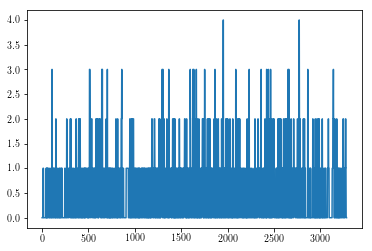

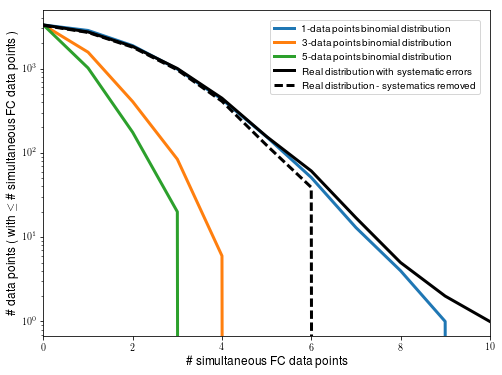

In [3]:
loc = 'stars_shortlist/{}/results/{}/results'.format(cluster,test)
oid_list, sys, overlap = systematics_wrap(loc, oid_list, test, cluster, maxpoints=6, display=True)

In [4]:
try:
    sys_s = pd.read_csv('stars_shortlist/{0}/results/{1}/results/{0}_systematics.csv'.format(cluster,test),
                   header=None,usecols=[1])
    print(sys_s.shape)
except ValueError:
    print('No systematics.')
sys

(33, 1)


0      140
1      141
2      142
3      143
4      144
5      602
6      603
7      604
8      605
9      785
10     786
11     787
12    1228
13    1229
14    1230
15    1231
16    1286
17    1287
18    1288
19    1596
20    1597
21    1598
22    1635
23    1636
24    1637
25    2023
26    2024
27    2025
28    2026
29    2027
30    2184
31    2185
32    2186
dtype: int64

## Match target pixel files with light curve time series

In [5]:
os.chdir('/work1/eilin/appaloosa/appaloosa')
#oid_list.remove(211123901)
#os.chdir('stars_shortlist/{}'.format(cluster))
flux, flares, tpfs = wrap_tpf_time_match(oid_list, cluster, test, C)

211101696
1
211021827
2
211038211
3
211025925
4
210964488
5
210882573
6
211038222
7
210888723
8
211079188
9
211060762
10
211142685
11
211154974
12
211030057
13
211054634
14
211046446
15
211105839
16
210880560
17
211083317
18
211101750
19
211030074
20
211122237
21
211062846
22
211101761
23
211095624
24
211142730
25
211093581
26
211091536
27
211069011
28
211007577
29
211040347
30
211046494
31
211089510
32
211085419
33
211177579
34
211013743
35
211105906
36
211103863
37
210950265
38
211171449
39
211073154
40
210978953
41
210915466
42
210995339
43
211083408
44
210862226
45
210944157
46
211079332
47
211026087
48
211042471
49
211056809
50
210878635
51
210966700
52
210974893
53
211015853
54
211038382
55
211065006
56
211103923
57
210983092
58
211038389
59
211093684
60
211044536
61
210872505
62
210960579
63
211015877
64
211036360
65
210917578
66
211063000
67
211034329
68
211138781
69
210940129
70
211056865
71
211103969
72
211007717
73
211077349
74
211034343
75
211060969
76
211112171
77
21102820

FileNotFoundError: [Errno 2] No such file or directory: 'ktwo211023137-c04_lpd-targ.fits.gz'

In [ ]:
from astropy.io import fits
f = fits.open('stars_shortlist/Pleiades/ktwo211123901-c04_lpd-targ.fits.gz')
f.info()

### Remove thruster firings

In [ ]:

def remove_thruster_firings(tpfs, flux, flares, oid):
    remove = []
    thr = []
    for i in range(len(tpfs[oid].hdulist[1].data['FLUX'])): 
        if tpfs[oid].hdulist[1].data['QUALITY'][i] > 545288:#flag values are summed up!
            thr.append(i)
            remove.append(tpfs[oid].bkjd(i))
            try:
                remove.append(tpfs[oid].bkjd(i-1))
            except IndexError:
                print('IndexError -1')
                pass
            try:
                remove.append(tpfs[oid].bkjd(i+1))
            except IndexError:
                print('IndexError +1')
                pass
    remove_id = []
    for rt in sorted(list(set(remove))):
        rem_id = flux[oid].index.values[np.round(flux[oid].time,6) == np.round(rt,6)]
        if rem_id != []:
            remove_id.append(rem_id)

    isflare = edges_to_bool2(flares[oid],flux[oid])
    new_isflare = np.array(isflare)
    new_flags = np.array(flux[oid].tpf_flags)
    for id_ in remove_id:
        if isflare[id_] == 1.:
            for j, row in flares[oid].iterrows():
                if (row.istart <= id_) & (row.istop+1 >=id_):
                    new_isflare[row.istart:row.istop+1] = 0
                    new_flags[row.istart:row.istop+1] = 0

    flux[oid]['isflare'] = isflare
    flux[oid]['new_isflare'] = new_isflare
    flux[oid]['new_tpf_flags'] = new_flags
    return thr


def remove_systematics2(flux,test,cluster,oid):

    s = pd.read_csv('stars_shortlist/{1}/results/{0}/results/{1}_systematics.csv'.format(test,cluster),names=['systematics']).systematics.tolist()
    flux[oid]['tpf_flags_wo_systematics'] = np.array(flux[oid].tpf_flags)
    flux[oid]['isflare_wo_systematics'] = np.array(flux[oid]['isflare'])
    flux[oid]['tpf_flags_wo_systematics'].iloc[s]= 0
    flux[oid]['isflare_wo_systematics'].iloc[s]= 0
    return

def rtf(tpfs,flux,flares,test,cluster,oid):
    print(oid)
    dp = remove_thruster_firings(tpfs, flux, flares, oid)
    remove_systematics2(flux, test, cluster, oid)
    
    flux[oid]['isflare_no_sys_no_thruster'] = (flux[oid].new_isflare == 1.) & (flux[oid].isflare_wo_systematics == 1.)
    
    start_stop = bool_to_edges(flux[oid].isflare_no_sys_no_thruster)
    flares[oid] = flares[oid].join(start_stop,rsuffix='_no_sys_no_thruster')
    
    #flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))

    flares[oid].to_csv('stars_shortlist/{}/results/{}/results/{}_flares.csv'.format(cluster,test,oid))
    flux[oid].to_csv('stars_shortlist/{}/results/{}/results/{}_flux.csv'.format(cluster,test,oid))
    return dp


#oid_list.remove(211066477)
for oid in oid_list:
    dp = rtf(tpfs,flux,flares,test,cluster,oid)


In [ ]:
dp = rtf(tpfs,flux,flares,test,cluster,oid_list[0])
s = len(set(sys_s[1].tolist()+dp))
print(len(dp),len(sys_s[1].tolist()),s,sys_s[1].tolist()+dp)
sum([(flux[oid].shape[0]-s)*29.4/60./24./365.25 for oid in oid_list])

### Decompose flags

In [ ]:


tot = np.asarray([flux[i].shape[0] for i in oid_list]).mean()
#print(np.asarray([flux[i].shape[0] for i in oid_list]).std())
thruster = np.asarray([(flux[i].tpf_flags[flux[i].tpf_flags > 524287./2.]).count() for i in oid_list]).mean()
#thruster/tot
# cal=[]
# for i in oid_list:
#     c = 0
#     for x in flux[i].tpf_flags:
#         if 8192 in flagdecomp(int(x),decomp=[]):
#             c+=1
#     cal.append(c)
print(tot)

### Appendix, scrambled pieces

In [ ]:
location = 'stars_shortlist/{}/results/{}'.format(cluster,test)
maxlen, seq = generate_sequence(oid_list, location)


In [ ]:
overlap_dirty, overlap_clean, p, remove = remove_systematics(seq,maxlen,maxpoints=4)

In [ ]:
inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=True)

In [ ]:
display_comparison(inflated_binoms, overlap_dirty, overlap_clean, test)